In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Data/clean_2.csv')

In [3]:
df

,Open,Close,Volume,Year,Month,Day
0,28.794172,29.519140,212976,2002,8,12
1,29.556316,29.119476,153576,2002,8,13
2,29.184536,27.111877,822776,2002,8,14
3,27.111877,27.111877,0,2002,8,15
4,26.972458,27.046812,811856,2002,8,16
...,...,...,...,...,...,...
4458,530.907530,529.713257,2320754,2021,9,24
4459,530.907530,529.713257,1673362,2021,9,27
4460,530.907530,529.713257,2253075,2021,9,28
4461,530.907530,529.713257,2489161,2021,9,29


# Split my data into X and Target y columns

In [4]:
X = df.drop(['Close'], axis =1)
y = df['Close']

# Import Train Test Split

In [5]:
from sklearn.model_selection import train_test_split, learning_curve
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=42)

# Scaling 

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
#  Scaling
num_cols = X_train.select_dtypes(include=['int', 'float']).columns

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Import all required models of Machine learning 

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

linear model training



LinearRegression:
Train R²: 0.9844947557260106
Test R²: 0.9749813484516651
Train MSE: 6061.778295696357
Test MSE: 9526.994957898441
R² Gap: 0.009513407274345576
traing cv score [0.97062911 0.98404636 0.99910836 0.98375697 0.98439956]
testing cv score [0.99795747 0.99858366 0.93624431 0.93902897 0.99864018]


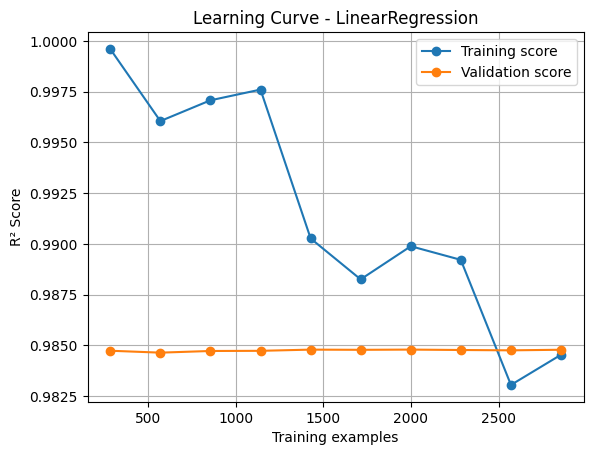

In [8]:
# LinearRegression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# cross validation both data train and test data
cv = KFold(n_splits=5, shuffle=True, random_state=42)
lr_train_cv = cross_val_score(lr, X_train, y_train, cv=cv, scoring='r2')
lr_test_cv = cross_val_score(lr, X_test, y_test, cv=cv, scoring='r2')

# Metrics
print("\nLinearRegression:")
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("R² Gap:", r2_score(y_train, y_train_pred) - r2_score(y_test, y_test_pred))
print('traing cv score', lr_train_cv)
print('testing cv score', lr_test_cv)

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    lr, X_train, y_train, cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation score')
plt.title("Learning Curve - LinearRegression")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc='best')
plt.grid(True)
plt.show()

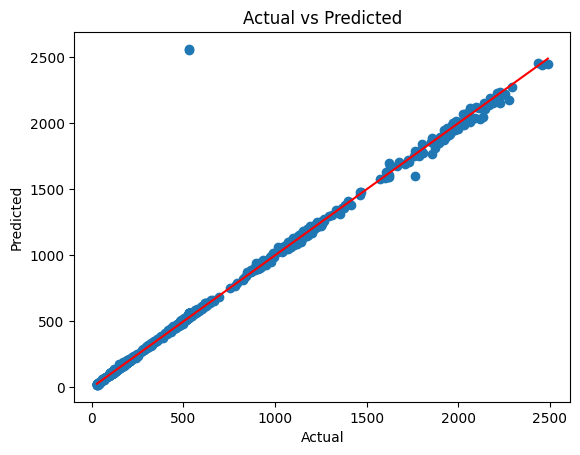

In [9]:
# Actual pediction plot
y_pred = lr.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

Stacking model training

In [10]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor

# tunned the model
estimators = [
    ('rf', RandomForestRegressor( n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4, max_features='sqrt',
        bootstrap=True, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.1, reg_lambda=1.0, random_state=42))
]

stacking_model = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor(n_estimators=50,
        max_depth=8,random_state=42),passthrough=True)

# train the model
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1))/ (n-p-1)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
sta_train_cv = cross_val_score(stacking_model, X_train, y_train, cv = cv, scoring = 'r2')
sta_test_cv = cross_val_score(stacking_model, X_test, y_test, cv=5, scoring='r2')

print("R²:", r2)
print("MSE:", mse)
print("MAE:", mae)
print('adj_r2', adj_r2)
print('traing cv score', sta_train_cv)
print('testing cv score', sta_test_cv)

R²: 0.990143519500069
MSE: 3753.305402733301
MAE: 13.028179969470356
adj_r2 0.9900879587306217
traing cv score [0.97398087 0.98183715 0.9912533  0.97852512 0.9856205 ]
testing cv score [0.98381948 0.99665569 0.99935688 0.99033669 0.98991905]


Stacking Model:
Train R²: 0.9905280633944011
Test R²: 0.990143519500069
Train MSE: 3703.055477194252
Test MSE: 3753.305402733301
R² Gap: 0.00038454389433217884


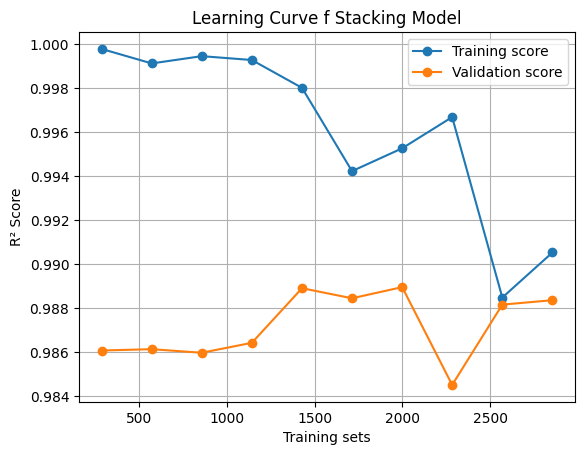

In [11]:

y_train_pred = stacking_model.predict(X_train)
y_test_pred = stacking_model.predict(X_test)
# Metrics
print("Stacking Model:")
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("R² Gap:", r2_score(y_train, y_train_pred) - r2_score(y_test, y_test_pred))

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(stacking_model, X_train, y_train, cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation score')
plt.title("Learning Curve f Stacking Model")
plt.xlabel("Training sets")
plt.ylabel("R² Score")
plt.legend(loc='best')
plt.grid(True)
plt.show()

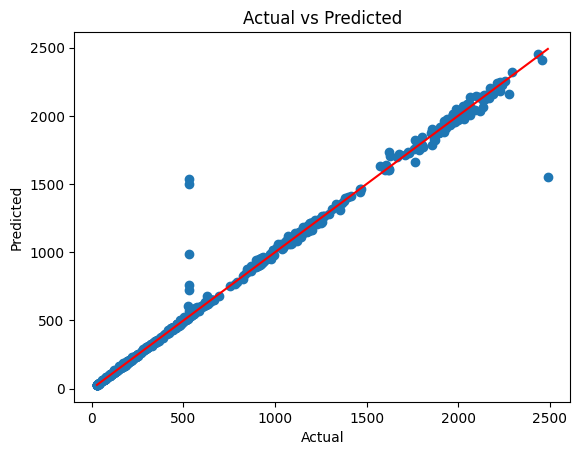

In [ ]:
# Actual pediction plot
y_pred = stacking_model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

# Save this model using pipelien

In [14]:
import pandas as pd 
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline

#  load again the data set
df = pd.read_csv('../Data/clean_2.csv')

# set target column 
target_col = ['Close']
num_col = ['Open', 'Volume', 'Year', 'Month', 'Day']
categorical_col = ['DayOfWeek']

# Set X and y 
X = df[num_col]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

preprocessing = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_col)
])


# create estimator 
estimators = [
    ('rf', RandomForestRegressor( n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4, max_features='sqrt',
        bootstrap=True, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.1, reg_lambda=1.0, random_state=42))
]


#  creating a pipe line
pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor(n_estimators=50,
        max_depth=8,random_state=42),passthrough=True))
])
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, 'model.pkl')
print('model successfully dumped')

c:\Users\Priyanshu pandey\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_stacking.py:955: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model successfully dumped
